In [23]:
import os
import numpy as np
import pandas as pd

%matplotlib inline

import torch
torch.cuda.is_available()

True

In [3]:
!pip3 install flair

     |████████████████████████████████| 143kB 6.2MB/s eta 0:00:01
  Created wheel for segtok: filename=segtok-1.5.7-cp36-none-any.whl size=23257 sha256=7f5d24b916a509bb98d3e5524f6a434a7a9380069fda34442a36475ed19afbac
  Stored in directory: /tmp/.cache/pip/wheels/15/ee/a8/6112173f1386d33eebedb3f73429cfa41a4c3084556bcee254
  Created wheel for sqlitedict: filename=sqlitedict-1.6.0-cp36-none-any.whl size=14689 sha256=4c8225b38738aeabf1934c8fb21bc64833007eed313d2d71c0c03a6a99aca530
  Stored in directory: /tmp/.cache/pip/wheels/bd/57/d3/907c3ee02d35e66f674ad0106e61f06eeeb98f6ee66a6cc3fe
Successfully built segtok sqlitedict


> ## Create a Corpus

### 1) Load from simple CSV file

In [4]:
from flair.datasets import CSVClassificationCorpus

ImportError: cannot import name 'CSVClassificationCorpus'

Great development..

### 2) FastText Format

In [5]:
from flair.data import Corpus
from flair.datasets import ClassificationCorpus

In [6]:
FILE_PATH = "../input/bbctext/bbc-text.csv"
DATASET_FOLDER_PATH = "splitted_data"

column_name = {
    "text": "text",
    "label": "category"
}

# file format
__label__<label_1> <text>
__label__<label_1> __label__<label_2> <text>

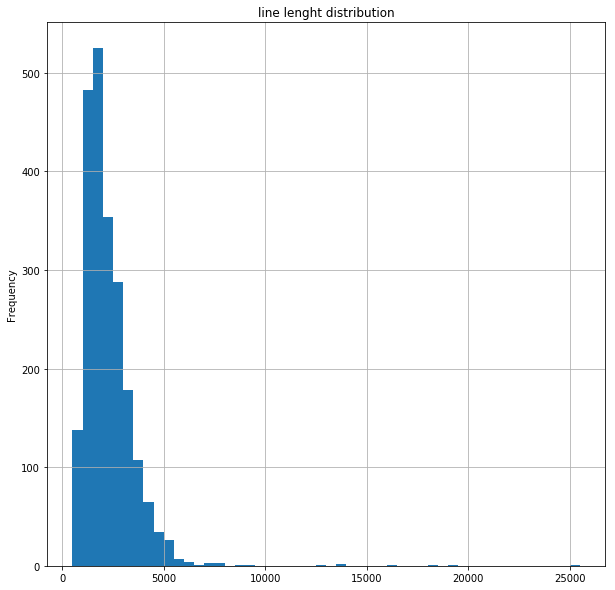

In [7]:
data_df = pd.read_csv(FILE_PATH).sample(frac=1)
data_df[column_name["label"]] = '__label__' + data_df[column_name["label"]].astype(str)

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

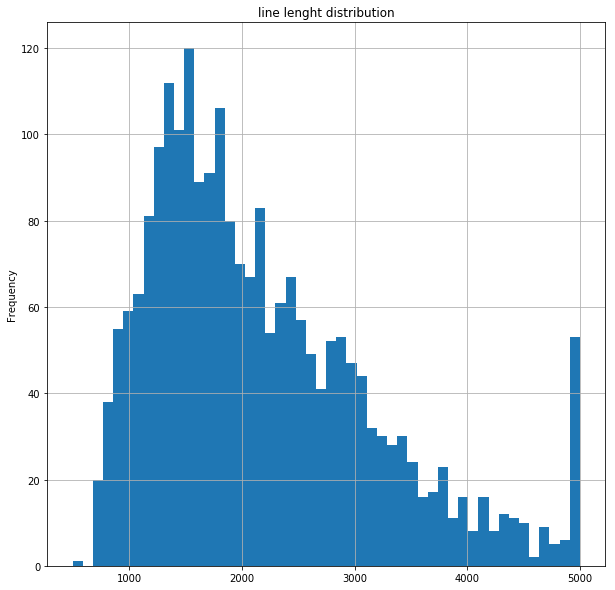

In [8]:
import re
from string import digits, punctuation

def clear_text(text, is_all_lower=True):
    punct = re.sub(r'[\.,!?&\-]', '', punctuation)
    punctuation_table = str.maketrans({key: "#" for key in punct})
    for char in ["\"", "\'"]:
        del punctuation_table[ord(char)]
    
    review_cleaned = text.apply(lambda x: re.sub(r'[^\x00-\x7F]', ' ', x))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r'[0-9]', '9', x))
    review_cleaned = review_cleaned.apply(lambda x: x.translate(punctuation_table))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r' +', ' ', x))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r' (?=[\.,!?&\-])','', x))
    
    if is_all_lower:
        review_cleaned = review_cleaned.str.lower()
        
    return review_cleaned

data_df[column_name["text"]] = clear_text(data_df["text"])
data_df[column_name["text"]] = data_df[column_name["text"]].apply(lambda x: x[:5000])

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

In [9]:
if not os.path.exists(DATASET_FOLDER_PATH):
    os.makedirs(DATASET_FOLDER_PATH)
data_df.iloc[0: int(len(data_df)*0.8)].to_csv(os.path.join(DATASET_FOLDER_PATH, 'train.csv'), sep='\t', index = False, header = False)
data_df.iloc[int(len(data_df)*0.8): int(len(data_df)*0.9)].to_csv(os.path.join(DATASET_FOLDER_PATH, 'dev.csv'), sep='\t', index = False, header = False)
data_df.iloc[int(len(data_df)*0.9): ].to_csv(os.path.join(DATASET_FOLDER_PATH, 'test.csv'), sep='\t', index = False, header = False);

In [10]:
corpus = ClassificationCorpus(DATASET_FOLDER_PATH)

2019-08-10 13:04:26,097 Reading data from splitted_data
2019-08-10 13:04:26,098 Train: splitted_data/train.csv
2019-08-10 13:04:26,108 Dev: splitted_data/dev.csv
2019-08-10 13:04:26,114 Test: splitted_data/test.csv


Each line in a corpus is converted to a Sentence object annotated with the labels.

## Check distribution

In [11]:
train_df = pd.read_csv("splitted_data/train.csv", names=["label", "text"], delimiter="\t")
train_df.label.value_counts()

__label__business         414
__label__sport            405
__label__politics         339
__label__tech             316
__label__entertainment    306
Name: label, dtype: int64

In [12]:
val_df = pd.read_csv("splitted_data/dev.csv", names=["label", "text"], delimiter="\t")
val_df.label.value_counts()

__label__sport            55
__label__business         49
__label__politics         43
__label__tech             41
__label__entertainment    34
Name: label, dtype: int64

In [13]:
test_df = pd.read_csv("splitted_data/test.csv", names=["label", "text"], delimiter="\t")
test_df.label.value_counts()

__label__sport            51
__label__business         47
__label__entertainment    46
__label__tech             44
__label__politics         35
Name: label, dtype: int64

## Training a Model

## Glove

In [14]:
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.training_utils import EvaluationMetric
from flair.visual.training_curves import Plotter

In [15]:
MODEL_FOLDER_PATH = "model/GLOVE"
if not os.path.exists(MODEL_FOLDER_PATH):
    os.makedirs(MODEL_FOLDER_PATH)

In [16]:
params_train = {
    "word_emb": 'glove',
    "flair_emb_forward": 'news-forward-fast',
    "flair_emb_backward": 'news-backward-fast',
    "hidden_size": 256,
    "reproject_words_dimension": 128,
    "max_epoch": 20,
    "evaluation_metric": EvaluationMetric.MICRO_ACCURACY
}

word_embeddings = [WordEmbeddings(params_train["word_emb"]), FlairEmbeddings(params_train["flair_emb_forward"]),
                   FlairEmbeddings(params_train["flair_emb_backward"])]

document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=params_train["hidden_size"],
                                            reproject_words=True, reproject_words_dimension=params_train["reproject_words_dimension"])

classifier = TextClassifier(document_embeddings, label_dictionary=corpus.make_label_dictionary(), multi_label=False)

trainer = ModelTrainer(classifier, corpus)

2019-08-10 13:04:43,686 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmpugv24qo7


100%|██████████| 160000128/160000128 [00:03<00:00, 47101536.71B/s]

2019-08-10 13:04:47,255 copying /tmp/tmpugv24qo7 to cache at /tmp/.flair/embeddings/glove.gensim.vectors.npy


2019-08-10 13:04:47,459 removing temp file /tmp/tmpugv24qo7
2019-08-10 13:04:47,549 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim not found in cache, downloading to /tmp/tmpvxjykmoq


100%|██████████| 21494764/21494764 [00:00<00:00, 44689502.57B/s]

2019-08-10 13:04:48,186 copying /tmp/tmpvxjykmoq to cache at /tmp/.flair/embeddings/glove.gensim


2019-08-10 13:04:48,221 removing temp file /tmp/tmpvxjykmoq
2019-08-10 13:04:49,591 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-forward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmp26c5c4_c


100%|██████████| 19689779/19689779 [00:00<00:00, 40711385.80B/s]

2019-08-10 13:04:50,232 copying /tmp/tmp26c5c4_c to cache at /tmp/.flair/embeddings/lm-news-english-forward-1024-v0.2rc.pt


2019-08-10 13:04:50,266 removing temp file /tmp/tmp26c5c4_c
2019-08-10 13:04:58,496 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-backward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmplp3l0w38


100%|██████████| 19689779/19689779 [00:00<00:00, 41783879.62B/s]

2019-08-10 13:04:59,104 copying /tmp/tmplp3l0w38 to cache at /tmp/.flair/embeddings/lm-news-english-backward-1024-v0.2rc.pt


2019-08-10 13:04:59,134 removing temp file /tmp/tmplp3l0w38
2019-08-10 13:05:18,612 {'entertainment', 'business', 'tech', 'sport', 'politics'}
2019-08-10 13:05:37,094 ----------------------------------------------------------------------------------------------------
2019-08-10 13:05:37,095 Evaluation method: MICRO_ACCURACY
2019-08-10 13:05:37,359 ----------------------------------------------------------------------------------------------------
2019-08-10 13:05:45,093 epoch 1 - iter 0/56 - loss 1.65959835
2019-08-10 13:06:04,878 epoch 1 - iter 5/56 - loss 1.62161018
2019-08-10 13:06:22,172 epoch 1 - iter 10/56 - loss 1.60224291
2019-08-10 13:06:39,550 epoch 1 - iter 15/56 - loss 1.59083848
2019-08-10 13:06:59,287 epoch 1 - iter 20/56 - loss 1.57231123
2019-08-10 13:07:17,063 epoch 1 - iter 25/56 - loss 1.55289903
2019-08-10 13:07:33,273 epoch 1 - iter 30/56 - loss 1.52965710
2019-08-10 13:07:52,673 epoch 1 - iter 35/56 - loss 1.51203109
2019-08-10 13:08:09,301 epoch 1 - iter 40/56 - 

{'test_score': 0.9103,
 'dev_score_history': [0.3649,
  0.5766,
  0.6396,
  0.6486,
  0.7072,
  0.7207,
  0.545,
  0.6532,
  0.7748,
  0.7568,
  0.7477,
  0.6757,
  0.7793,
  0.7748,
  0.8108,
  0.6171,
  0.7883,
  0.7793,
  0.7342,
  0.8153,
  0.8153,
  0.8784,
  0.8153,
  0.8378,
  0.8964,
  0.8874,
  0.8964,
  0.8559,
  0.8559,
  0.9369,
  0.9279,
  0.8964,
  0.9009,
  0.9234,
  0.9234,
  0.9099,
  0.9324,
  0.9279,
  0.9099,
  0.9054,
  0.9144,
  0.9279,
  0.9234,
  0.9324,
  0.9234,
  0.9144,
  0.9189,
  0.9189,
  0.9324,
  0.9324],
 'train_loss_history': [1.433325280036245,
  1.160244141306196,
  1.0401128743376051,
  0.8961353834186282,
  0.8851458520761558,
  0.7959711445229394,
  0.7706918578062739,
  0.7039548893060003,
  0.691913115126746,
  0.7099557316729,
  0.637701366096735,
  0.6290836978171553,
  0.6026883308908769,
  0.5596120788582734,
  0.5565658480461154,
  0.5881381896989686,
  0.5114483931767089,
  0.5047071294060775,
  0.5334925027564168,
  0.3668162346418415,
 

In [ ]:
learning_rate_tsv = trainer.find_learning_rate(MODEL_FOLDER_PATH, 'learning_rate.tsv')

plotter = Plotter()
plotter.plot_learning_rate(learning_rate_tsv)

In [ ]:
trainer.train(MODEL_FOLDER_PATH, max_epochs=params_train["max_epoch"], evaluation_metric=params_train["evaluation_metric"])

## Plot training curves

In [ ]:
from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves(os.path.join(MODEL_FOLDER_PATH, 'loss.tsv'))
plotter.plot_weights(os.path.join(MODEL_FOLDER_PATH, 'weights.txt'))